<a href="https://colab.research.google.com/github/skywalker0803r/Ricky/blob/master/%E7%8E%89%E5%B1%B1%E9%8A%80%E8%A1%8C%E6%AF%94%E8%B3%BD_catboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import warnings 
warnings.simplefilter('ignore')
import seaborn as sns
import matplotlib.pyplot as plt

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
中文map = {'bacno':'歸戶帳號','txkey':'交易序號','locdt':'授權日期','loctm':'授權時間','cano':'交易卡號',
         'contp':'交易類別','etymd':'交易型態','mchno':'特店代號','acqic':'收單行代碼','mcc':'MCC_CODE',
         'conam':'交易金額-台幣(經過轉換)','ecfg':'網路交易註記','insfg':'分期交易註記','iterm':'分期期數',
         'stocn':'消費地國別','scity':'消費城市','stscd':'狀態碼','ovrlt':'超額註記碼','flbmk':'Fallback註記',
         'hcefg':'支付型態','csmcu':'消費地幣別','flg_3dsmk':'3DS交易註記','fraud_ind':'盜刷註記'}

# train

In [3]:
import pandas as pd
train = pd.read_csv("/content/drive/My Drive/玉山人工智慧比賽數據/train_特徵工程完.csv",index_col=0)
print(train.shape)
train.head()

(1521787, 24)


,stscd,ecfg,stocn,acqic,etymd,loctm,scity,hcefg,contp,conam,insfg,ovrlt,flg_3dsmk,csmcu,mchno,cano,mcc,flbmk,bacno,mchno_stscd_2_norm_count,acqic_ecfg_0_norm_count,risk_mchno,txkey,fraud_ind
0,0,0,102,6862,0,61954,0,5,5,16158,0,0,0,0,59034,37846,457,0,112785,0.001044,1.000000,0,516056,0
1,0,0,102,0,2,38216,5795,0,5,13693,0,0,0,0,0,45476,451,0,133951,0.000016,1.000000,0,4376,0
2,0,0,102,6862,0,54640,0,5,5,16158,0,0,0,0,59034,187354,457,0,15350,0.001044,1.000000,0,483434,0
3,0,0,102,6697,5,62128,3267,5,5,40413,0,0,0,62,50185,29812,247,0,156492,0.000000,0.764562,0,1407164,0
4,0,0,102,5959,4,65231,5795,5,5,25962,0,0,0,62,93290,80881,263,0,105534,0.000000,0.916687,0,1051004,0


# test

In [4]:
test = pd.read_csv("/content/drive/My Drive/玉山人工智慧比賽數據/test_特徵工程完.csv",index_col=0)
test_txkey = test["txkey"]
print(test.shape)
test.head()

(421665, 23)


,stscd,ecfg,stocn,acqic,etymd,loctm,scity,hcefg,contp,conam,insfg,ovrlt,flg_3dsmk,csmcu,mchno,cano,mcc,flbmk,bacno,mchno_stscd_2_norm_count,acqic_ecfg_0_norm_count,risk_mchno,txkey
1521787,0,0,102,6862,0,77950,0,5,5,16158,0,0,0,0,59060,116168,457,0,162489,0.00193,1.0,0,592489
1521788,0,0,102,6862,0,79549,0,5,5,16158,0,0,0,0,59060,116168,457,0,162489,0.00193,1.0,0,592452
1521789,0,0,102,6862,0,60355,0,5,5,16158,0,0,0,0,59060,116168,457,0,162489,0.00193,1.0,0,590212
1521790,0,0,102,6862,0,60296,0,5,5,16158,0,0,0,0,59060,116168,457,0,162489,0.00193,1.0,0,590209
1521791,0,0,102,6862,0,77933,0,5,5,16158,0,0,0,0,59060,116168,457,0,162489,0.00193,1.0,0,592488


# 定義 features & cat_features & target

In [5]:
# all features
features = train.drop(['fraud_ind', # just target
                       'txkey', # just like index
                       #'locdt',# just date
                       ],axis=1).columns.tolist()

# cat_features
cat_features = sorted(list(set(features)&set(中文map.keys())))+['risk_mchno']

y_name = 'fraud_ind'

print(len(features),features)
print(len(cat_features),cat_features)
print(len([y_name]),[y_name])

22 ['stscd', 'ecfg', 'stocn', 'acqic', 'etymd', 'loctm', 'scity', 'hcefg', 'contp', 'conam', 'insfg', 'ovrlt', 'flg_3dsmk', 'csmcu', 'mchno', 'cano', 'mcc', 'flbmk', 'bacno', 'mchno_stscd_2_norm_count', 'acqic_ecfg_0_norm_count', 'risk_mchno']
20 ['acqic', 'bacno', 'cano', 'conam', 'contp', 'csmcu', 'ecfg', 'etymd', 'flbmk', 'flg_3dsmk', 'hcefg', 'insfg', 'loctm', 'mcc', 'mchno', 'ovrlt', 'scity', 'stocn', 'stscd', 'risk_mchno']
1 ['fraud_ind']


# both / test

In [6]:
f = {}
for col in cat_features:
  both_value = set(train[col].unique())&set(test[col].unique())
  f[col] = len(both_value)/len(test[col].unique())
res = pd.DataFrame(f,index=['both/test']).T.sort_values(by='both/test',ascending=False)
res['中文'] = res.index.map(中文map)
res

,both/test,中文
risk_mchno,1.000000,NaN
stscd,1.000000,狀態碼
contp,1.000000,交易類別
ecfg,1.000000,網路交易註記
etymd,1.000000,交易型態
flbmk,1.000000,Fallback註記
flg_3dsmk,1.000000,3DS交易註記
ovrlt,1.000000,超額註記碼
insfg,1.000000,分期交易註記
loctm,0.990267,授權時間


# drop rare features

In [7]:
print(len(features))
try:
  features.remove('bacno')
  features.remove('cano')
except:
  pass
print(len(features))

22
20


In [8]:
print(len(cat_features))
try:
  cat_features.remove('bacno')
  cat_features.remove('cano')
except:
  pass
print(len(cat_features))

20
18


# 切分 train 跟 val

In [0]:
from sklearn.model_selection import KFold

kf = KFold(n_splits =5 ,random_state=42)
Folds = {}

for i,train_val_index in enumerate(kf.split(train.index)):
  Folds[i] = train_val_index

In [0]:
num_Fold = 0
train_index ,val_index = Folds[num_Fold]

In [0]:
val = train.loc[val_index,features+[y_name]]
train = train.loc[train_index,features+[y_name]]

# val 再切分 val_1,val_2

In [12]:
from sklearn.model_selection import train_test_split
val_1 ,val_2 = train_test_split(val[features+[y_name]] ,test_size=0.5 ,random_state=42)
print(train.shape)
print(val_1.shape)
print(val_2.shape)

(1217429, 21)
(152179, 21)
(152179, 21)


# 計算class weight

In [13]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

y_org = train[y_name].append(val[y_name])

class_weight_dict = dict(zip([0,1],
                             compute_class_weight(class_weight ='balanced',
                                                  classes = np.unique(y_org),
                                                  y = y_org)))
class_weight_dict = list(class_weight_dict.values())
class_weight_dict

[0.5067785287645394, 37.381159420289855]

# scaler 數值特徵

In [14]:
#產生數值特徵列表
num_feat = list(set(features)^set(cat_features))
num_feat

['acqic_ecfg_0_norm_count', 'mchno_stscd_2_norm_count']

In [0]:
from sklearn.preprocessing import StandardScaler

# fit on full data's num_feat
scaler =  StandardScaler().fit(train[num_feat].append(val[num_feat]).append(test[num_feat]))

# transform each data's num_feat
train[num_feat] = scaler.transform(train[num_feat])
val_1[num_feat] = scaler.transform(val_1[num_feat])
val_2[num_feat] = scaler.transform(val_2[num_feat])
test[num_feat] = scaler.transform(test[num_feat])

In [16]:
import gc
gc.collect()

0

# modelling

準備類別特徵

In [17]:
train[features].columns

Index(['stscd', 'ecfg', 'stocn', 'acqic', 'etymd', 'loctm', 'scity', 'hcefg',
       'contp', 'conam', 'insfg', 'ovrlt', 'flg_3dsmk', 'csmcu', 'mchno',
       'mcc', 'flbmk', 'mchno_stscd_2_norm_count', 'acqic_ecfg_0_norm_count',
       'risk_mchno'],
      dtype='object')

In [18]:
cate_features_index = np.where(train[features].dtypes != float)[0]
cate_features_index

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       19])

# 定義模型

In [0]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(
    class_weights = [1.0,2.5],#樣本不平衡
    iterations = 1000,# 跑幾次迭代
    loss_function = 'Logloss',#二分類問題
    eval_metric = 'F1',#主辦單位指定評估指標
    use_best_model = True,#最好model
    random_seed = 42,#真理
    task_type="GPU",#GPU加速
    )

# 訓練

In [29]:
model.fit(train[features],train[y_name], #訓練資料
          eval_set = (val_1[features],val_1[y_name]), #驗證資料
          cat_features = cate_features_index, #指定類別特徵
          )

Learning rate set to 0.164522
0:	learn: 0.6581927	test: 0.7039928	best: 0.7039928 (0)	total: 607ms	remaining: 10m 5s
1:	learn: 0.6553442	test: 0.7045299	best: 0.7045299 (1)	total: 1.02s	remaining: 8m 28s
2:	learn: 0.6564367	test: 0.7045598	best: 0.7045598 (2)	total: 1.48s	remaining: 8m 10s
3:	learn: 0.6376716	test: 0.6798915	best: 0.7045598 (2)	total: 1.97s	remaining: 8m 11s
4:	learn: 0.6393259	test: 0.6813447	best: 0.7045598 (2)	total: 2.5s	remaining: 8m 17s
5:	learn: 0.6415820	test: 0.6861649	best: 0.7045598 (2)	total: 2.94s	remaining: 8m 7s
6:	learn: 0.6436381	test: 0.6874616	best: 0.7045598 (2)	total: 3.3s	remaining: 7m 48s
7:	learn: 0.6452804	test: 0.6867193	best: 0.7045598 (2)	total: 3.71s	remaining: 7m 39s
8:	learn: 0.6468425	test: 0.6866256	best: 0.7045598 (2)	total: 4.17s	remaining: 7m 39s
9:	learn: 0.6655481	test: 0.7061193	best: 0.7061193 (9)	total: 4.56s	remaining: 7m 31s
10:	learn: 0.6639446	test: 0.7047255	best: 0.7061193 (9)	total: 4.96s	remaining: 7m 25s
11:	learn: 0.66

# plot train history

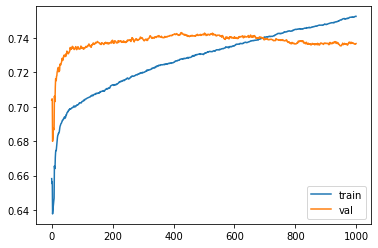

In [36]:
plt.plot(model.evals_result_['learn']['F1:use_weights=true'],label='train')
plt.plot(model.evals_result_['validation']['F1:use_weights=true'],label='val')
plt.legend()
plt.show()

# plot features importance

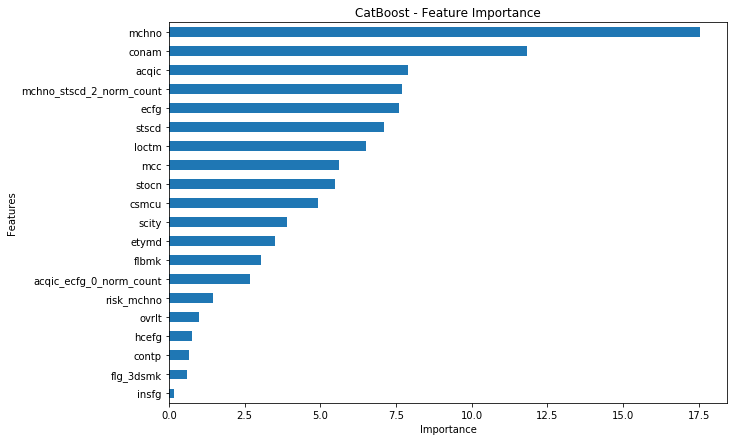

In [37]:
fea_imp = pd.DataFrame({'imp': model.feature_importances_, 'col': features})
fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-30:]
fea_imp.plot(kind='barh', x='col', y='imp', figsize=(10, 7), legend=None)
plt.title('CatBoost - Feature Importance')
plt.ylabel('Features')
plt.xlabel('Importance');

# val_2's F1 report

In [38]:
from sklearn.metrics import classification_report 

val_2_pred_01 = pd.Series(model.predict(val_2[features])).apply(round)

print(classification_report(val_2[y_name],val_2_pred_01,target_names=['0','1']))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    150093
           1       0.67      0.64      0.66      2086

    accuracy                           0.99    152179
   macro avg       0.83      0.82      0.83    152179
weighted avg       0.99      0.99      0.99    152179



# 產生submission

In [39]:
submission = pd.DataFrame({"txkey":test_txkey,
                           "fraud_ind":model.predict(test[features])})

# to [0,1] 
submission["fraud_ind"] = submission["fraud_ind"].apply(round)

# value_counts
print(submission["fraud_ind"].value_counts())
submission.head()

0    415982
1      5683
Name: fraud_ind, dtype: int64


,txkey,fraud_ind
1521787,592489,0
1521788,592452,0
1521789,590212,0
1521790,590209,0
1521791,592488,0


# 這裡有個想法如果test上盜刷的比例 跟train上面盜刷的比例 愈相近愈好

In [40]:
train_p = round((train['fraud_ind'].value_counts()[1] / #盜刷樣本數
                len(train['fraud_ind']))*100 ,5) #總數

val_1_p = round((val_1['fraud_ind'].value_counts()[1] / #盜刷樣本數
                len(val_1['fraud_ind']))*100 ,5) #總數

val_2_p = round((val_2['fraud_ind'].value_counts()[1] / #盜刷樣本數
                len(val_2['fraud_ind']))*100 ,5) #總數

test_p = round((submission['fraud_ind'].value_counts()[1] / #盜刷樣本數
                len(submission['fraud_ind']))*100 ,5) #總數
pd.DataFrame({'train_p':train_p,
              'val_1_p':val_1_p,
              'val_2_p':val_2_p,
              'test_p':test_p},
               index=['盜刷比例%'])

,train_p,val_1_p,val_2_p,test_p
盜刷比例%,1.33018,1.36353,1.37075,1.34775


# 保存預測結果

In [0]:
submission.to_csv("./submission_catboost_Fold_0(add_class_weight&LogLoss&add_more_features&1000次迭代).csv")